# 選挙のデータ解析（世論調査と寄付）

このレクチャーでは、2012年のアメリカ大統領選挙について扱います。その内容にあまり詳しくない方は、以下が参考になると思います。
https://ja.wikipedia.org/wiki/2012%E5%B9%B4%E3%82%A2%E3%83%A1%E3%83%AA%E3%82%AB%E5%90%88%E8%A1%86%E5%9B%BD%E5%A4%A7%E7%B5%B1%E9%A0%98%E9%81%B8%E6%8C%99

基本的には民主党のオバマ候補と、共和党のロムニー候補の争いで、オバマ候補が勝利しました。

最初は、世論調査結果のデータを扱います。以下のような問題を設定してみましょう。

    1.) どのような人達が調査対象だったか？
    2.) 調査結果は、どちらの候補の有利を示しているか？
    3.) 態度未定の人達が世論調査に与えた影響は？
    4.) また、態度未定の人たちの動向は？
    5.) 投票者の気持ちは、時間ともにどう変化したか？
    6.) 討論会の影響を世論調査の結果から読み取ることができるか？
    
2つ目のデータセットについては、後半で。

まずはいつものように、必要なものをインポートします

In [3]:
import pandas as pd
from pandas import Series,DataFrame
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline
# Python2をお使いの場合は
from __future__ import division

データは、HuffPost Pollsterから持ってきます。[サイトはこちら](http://elections.huffingtonpost.com/pollster). 米国の選挙のデータですが、このコースが終わったあとに、このサイトの別のデータを解析するのにチャレンジしてみるのもよいかもしれません。

Webからデータととってくるのに便利な、requestsというモジュールを使います。インストールされていない場合は、[こちらを参照](http://docs.python-requests.org/en/latest/)してください。

CSV形式のテキストデータをファイルのように扱うために、StringIOを利用します。[StringIOの詳しい解説（英語）](http://pymotw.com/2/StringIO/) 

In [4]:
# Webからデータを取得するために、requestsをインポートします。
import requests

# CSVデータのために、StringIOをつかいます。
from io import StringIO
# Python2を使っているときは,以下のコードでimportします。
# from StringIO import StringIO

In [5]:
# データのURLです。
url = "http://elections.huffingtonpost.com/pollster/2012-general-election-romney-vs-obama.csv"

# requestsをつかってデータをtextとして取得します。
source = requests.get(url).text

# StringIOを使ってpandasのエラーを防ぎます。
poll_data = StringIO(source) 

早速、DataFrameにしましょう。

In [6]:
poll_df = pd.read_csv(poll_data)

# データの概要です。
poll_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 589 entries, 0 to 588
Data columns (total 14 columns):
Pollster                  589 non-null object
Start Date                589 non-null object
End Date                  589 non-null object
Entry Date/Time (ET)      589 non-null object
Number of Observations    567 non-null float64
Population                589 non-null object
Mode                      589 non-null object
Obama                     589 non-null int64
Romney                    589 non-null int64
Undecided                 422 non-null float64
Pollster URL              589 non-null object
Source URL                587 non-null object
Partisan                  589 non-null object
Affiliation               589 non-null object
dtypes: float64(2), int64(2), object(10)
memory usage: 69.0+ KB


最初の5行を表示します。

In [7]:
poll_df.head()

,Pollster,Start Date,End Date,Entry Date/Time (ET),Number of Observations,Population,Mode,Obama,Romney,Undecided,Pollster URL,Source URL,Partisan,Affiliation
0,Politico/GWU/Battleground,2012-11-04,2012-11-05,2012-11-06 2000-01-01 08:40:26 UTC,1000,Likely Voters,Live Phone,47,47,6,http://elections.huffingtonpost.com/pollster/p...,http://www.politico.com/news/stories/1112/8338...,Nonpartisan,None
1,UPI/CVOTER,2012-11-03,2012-11-05,2012-11-05 2000-01-01 18:30:15 UTC,3000,Likely Voters,Live Phone,49,48,NaN,http://elections.huffingtonpost.com/pollster/p...,NaN,Nonpartisan,None
2,Gravis Marketing,2012-11-03,2012-11-05,2012-11-06 2000-01-01 09:22:02 UTC,872,Likely Voters,Automated Phone,48,48,4,http://elections.huffingtonpost.com/pollster/p...,http://www.gravispolls.com/2012/11/gravis-mark...,Nonpartisan,None
3,JZ Analytics/Newsmax,2012-11-03,2012-11-05,2012-11-06 2000-01-01 07:38:41 UTC,1041,Likely Voters,Internet,47,47,6,http://elections.huffingtonpost.com/pollster/p...,http://www.jzanalytics.com/,Sponsor,Rep
4,Rasmussen,2012-11-03,2012-11-05,2012-11-06 2000-01-01 08:47:50 UTC,1500,Likely Voters,Automated Phone,48,49,NaN,http://elections.huffingtonpost.com/pollster/p...,http://www.rasmussenreports.com/public_content...,Nonpartisan,None


支持政党で分類します。アメリカは2大政党制で、大きく共和党（the Republican party)と民主党（the Democratic party）に分けられます。

In [8]:
# ちょっと分かりにくいので、世論調査の主体とその支持政党をまとめて見ます。
poll_df[['Pollster','Partisan','Affiliation']].sort('Pollster').drop_duplicates()

,Pollster,Partisan,Affiliation
401,ABC/Post,Nonpartisan,None
434,AP-GfK,Nonpartisan,None
90,ARG,Nonpartisan,None
132,Allstate/National Journal,Nonpartisan,None
304,Angus-Reid,Nonpartisan,None
366,Bloomberg,Nonpartisan,None
64,CBS,Nonpartisan,None
330,CBS/Times,Nonpartisan,None
559,CNN,Nonpartisan,None
571,Clarus,Nonpartisan,None


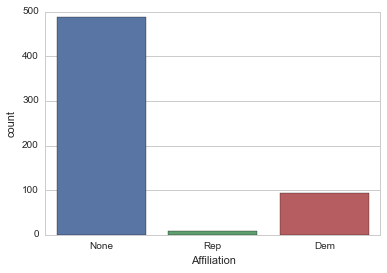

In [9]:
# affiliationで数を分類します。
sns.countplot('Affiliation',data=poll_df)

概ね中立のように見えますが、民主党寄りの調査主体が多いようにも見えます。このことは、頭に入れておいてもいいかもしれません。調査対象の人々の属性で層別化してみましょう。

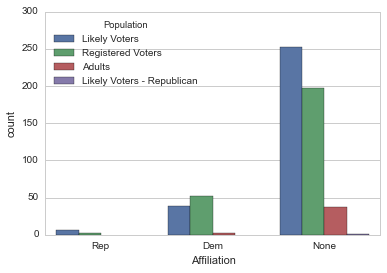

In [10]:
# 調査主体の支持政党を、調査対象で層別化します。
sns.countplot('Affiliation',data=poll_df,hue='Population', order=['Rep','Dem','None'])

概ね、選挙の投票に関連のある人々を対象にしているようですので、調査結果は信頼できそうです。
別の角度から解析を進めてみましょう。

In [11]:
poll_df.head()

,Pollster,Start Date,End Date,Entry Date/Time (ET),Number of Observations,Population,Mode,Obama,Romney,Undecided,Pollster URL,Source URL,Partisan,Affiliation
0,Politico/GWU/Battleground,2012-11-04,2012-11-05,2012-11-06 2000-01-01 08:40:26 UTC,1000,Likely Voters,Live Phone,47,47,6,http://elections.huffingtonpost.com/pollster/p...,http://www.politico.com/news/stories/1112/8338...,Nonpartisan,None
1,UPI/CVOTER,2012-11-03,2012-11-05,2012-11-05 2000-01-01 18:30:15 UTC,3000,Likely Voters,Live Phone,49,48,NaN,http://elections.huffingtonpost.com/pollster/p...,NaN,Nonpartisan,None
2,Gravis Marketing,2012-11-03,2012-11-05,2012-11-06 2000-01-01 09:22:02 UTC,872,Likely Voters,Automated Phone,48,48,4,http://elections.huffingtonpost.com/pollster/p...,http://www.gravispolls.com/2012/11/gravis-mark...,Nonpartisan,None
3,JZ Analytics/Newsmax,2012-11-03,2012-11-05,2012-11-06 2000-01-01 07:38:41 UTC,1041,Likely Voters,Internet,47,47,6,http://elections.huffingtonpost.com/pollster/p...,http://www.jzanalytics.com/,Sponsor,Rep
4,Rasmussen,2012-11-03,2012-11-05,2012-11-06 2000-01-01 08:47:50 UTC,1500,Likely Voters,Automated Phone,48,49,NaN,http://elections.huffingtonpost.com/pollster/p...,http://www.rasmussenreports.com/public_content...,Nonpartisan,None


オバマ、ロムニー、未定の3つの選択肢について、それぞれ平均的な支持率を計算してみます。

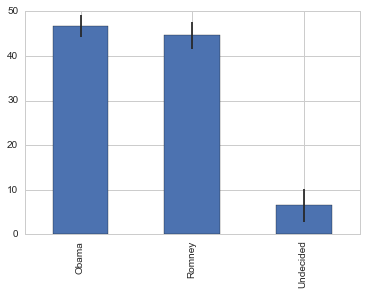

In [12]:
# 平均をとると、数値の列だけが残るので、いらないNumber of Observationsを削除します。
avg = pd.DataFrame(poll_df.mean()) 
avg.drop('Number of Observations',axis=0,inplace=True)

# 同じように、標準偏差を計算します。
std = pd.DataFrame(poll_df.std())
std.drop('Number of Observations',axis=0,inplace=True)

# pandas標準のplotで描画します。エラーバーも付けておきましょう。
avg.plot(yerr=std,kind='bar',legend=False)

未定の動向に注目しつつ、もう少し詳しく見ていくことにしましょう。

In [13]:
# 平均と標準偏差のDataFrameを連結します。
poll_avg = pd.concat([avg,std],axis=1)

# 名前を変えておきます。
poll_avg.columns = ['Average','STD']

poll_avg

,Average,STD
Obama,46.772496,2.448627
Romney,44.573854,2.927711
Undecided,6.549763,3.702235


<hr>

非常に接戦の選挙戦に見えます。ただ、未定の人達は、いざ投票が始まれば、どちらかに投票することになるので、その動向が注目されます。ここはひとまず、未定の人達が、半分ずつ、両候補へ分かれると仮定して、選挙戦の最終的な結果を推定してみましょう。

In [14]:
poll_df.head()

,Pollster,Start Date,End Date,Entry Date/Time (ET),Number of Observations,Population,Mode,Obama,Romney,Undecided,Pollster URL,Source URL,Partisan,Affiliation
0,Politico/GWU/Battleground,2012-11-04,2012-11-05,2012-11-06 2000-01-01 08:40:26 UTC,1000,Likely Voters,Live Phone,47,47,6,http://elections.huffingtonpost.com/pollster/p...,http://www.politico.com/news/stories/1112/8338...,Nonpartisan,None
1,UPI/CVOTER,2012-11-03,2012-11-05,2012-11-05 2000-01-01 18:30:15 UTC,3000,Likely Voters,Live Phone,49,48,NaN,http://elections.huffingtonpost.com/pollster/p...,NaN,Nonpartisan,None
2,Gravis Marketing,2012-11-03,2012-11-05,2012-11-06 2000-01-01 09:22:02 UTC,872,Likely Voters,Automated Phone,48,48,4,http://elections.huffingtonpost.com/pollster/p...,http://www.gravispolls.com/2012/11/gravis-mark...,Nonpartisan,None
3,JZ Analytics/Newsmax,2012-11-03,2012-11-05,2012-11-06 2000-01-01 07:38:41 UTC,1041,Likely Voters,Internet,47,47,6,http://elections.huffingtonpost.com/pollster/p...,http://www.jzanalytics.com/,Sponsor,Rep
4,Rasmussen,2012-11-03,2012-11-05,2012-11-06 2000-01-01 08:47:50 UTC,1500,Likely Voters,Automated Phone,48,49,NaN,http://elections.huffingtonpost.com/pollster/p...,http://www.rasmussenreports.com/public_content...,Nonpartisan,None


両候補の支持率と未定の割合を、手っ取り早くプロットしてみます。

Note: 時間が逆順になっているのに注意してください。また同じEnd Dateに複数のプロトがある場合があります。

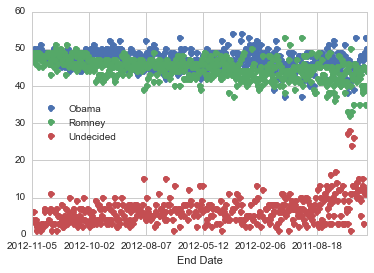

In [15]:
# 時間事に、支持率をプロットします。
poll_df.plot(x='End Date',y=['Obama','Romney','Undecided'],marker='o',linestyle='')

ちょっと見にくいので、両陣営の支持率の差を可視化するには、新しいデータを作って解析した方が良さそうです。

これは、前に株価のデータを解析したときのように、時系列のデータとして解析するのがよさそうです。
時間とともに変化する支持率を、datetimeモジュールを使って、時系列のデータとして扱ってみましょう。

In [16]:
from datetime import datetime

オバマとロムニーの支持率の差を計算し、新しい列に保存します。

In [17]:
# Differenceは「差」を意味する英単語です。
poll_df['Difference'] = (poll_df.Obama - poll_df.Romney)/100

poll_df.head()

,Pollster,Start Date,End Date,Entry Date/Time (ET),Number of Observations,Population,Mode,Obama,Romney,Undecided,Pollster URL,Source URL,Partisan,Affiliation,Difference
0,Politico/GWU/Battleground,2012-11-04,2012-11-05,2012-11-06 2000-01-01 08:40:26 UTC,1000,Likely Voters,Live Phone,47,47,6,http://elections.huffingtonpost.com/pollster/p...,http://www.politico.com/news/stories/1112/8338...,Nonpartisan,None,0.00
1,UPI/CVOTER,2012-11-03,2012-11-05,2012-11-05 2000-01-01 18:30:15 UTC,3000,Likely Voters,Live Phone,49,48,NaN,http://elections.huffingtonpost.com/pollster/p...,NaN,Nonpartisan,None,0.01
2,Gravis Marketing,2012-11-03,2012-11-05,2012-11-06 2000-01-01 09:22:02 UTC,872,Likely Voters,Automated Phone,48,48,4,http://elections.huffingtonpost.com/pollster/p...,http://www.gravispolls.com/2012/11/gravis-mark...,Nonpartisan,None,0.00
3,JZ Analytics/Newsmax,2012-11-03,2012-11-05,2012-11-06 2000-01-01 07:38:41 UTC,1041,Likely Voters,Internet,47,47,6,http://elections.huffingtonpost.com/pollster/p...,http://www.jzanalytics.com/,Sponsor,Rep,0.00
4,Rasmussen,2012-11-03,2012-11-05,2012-11-06 2000-01-01 08:47:50 UTC,1500,Likely Voters,Automated Phone,48,49,NaN,http://elections.huffingtonpost.com/pollster/p...,http://www.rasmussenreports.com/public_content...,Nonpartisan,None,-0.01


Difference列は、「Obama - Romney」です。正の数は、オバマのリードを意味します。

これを使って、支持率の差が時間とともに、どう変化したかを計算します。同じ期間に行われた調査もあるので、groupbyを使って、データを整理しましょう。

In [18]:
# as_index=Flaseにすると、0,1,2,... のindexを維持します。
poll_df = poll_df.groupby(['Start Date'],as_index=False).mean()

poll_df.head()

,Start Date,Number of Observations,Obama,Romney,Undecided,Difference
0,2009-03-13,1403,44,44,12,0.00
1,2009-04-17,686,50,39,11,0.11
2,2009-05-14,1000,53,35,12,0.18
3,2009-06-12,638,48,40,12,0.08
4,2009-07-15,577,49,40,11,0.09


時間とともに、支持率がどう変化したかを端的に可視化出来ます。

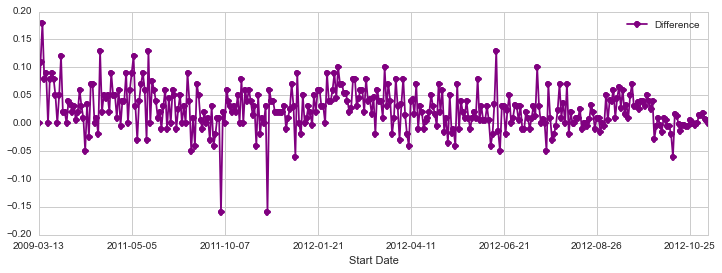

In [19]:
fig = poll_df.plot('Start Date','Difference',figsize=(12,4),marker='o',linestyle='-',color='purple')

候補者同士の討論会があった日付を、このプロットに描き込むと面白いかも知れません。

2012の討論会があったのは、10/3、10/11、10/22です。これらを描き込んでみましょう。

2012年の10月が、X軸上のいくつ目のデータなのかを知る必要があります。
ここは単純に、2012/10のデータを見て、どのindexをとればいいか確認することにしましょう。

In [20]:
poll_df[poll_df['Start Date'].apply(lambda x:x.startswith('2012-10'))]

,Start Date,Number of Observations,Obama,Romney,Undecided,Difference
329,2012-10-01,1746.000000,48.500000,46.000000,3.000000,0.025000
330,2012-10-02,590.000000,49.000000,45.000000,6.000000,0.040000
331,2012-10-04,1061.500000,45.833333,48.666667,6.000000,-0.028333
332,2012-10-05,1000.000000,46.000000,46.500000,7.000000,-0.005000
333,2012-10-06,895.000000,46.500000,45.500000,4.500000,0.010000
334,2012-10-07,1197.333333,47.000000,47.333333,4.666667,-0.003333
335,2012-10-08,2030.000000,46.500000,48.000000,5.000000,-0.015000
336,2012-10-10,1118.000000,48.000000,47.000000,3.500000,0.010000
337,2012-10-11,1335.250000,47.000000,46.500000,5.666667,0.005000
338,2012-10-12,1231.500000,46.500000,47.000000,6.500000,-0.005000


3日はデータが無いので、2日にします。ですので、330、337、347です。

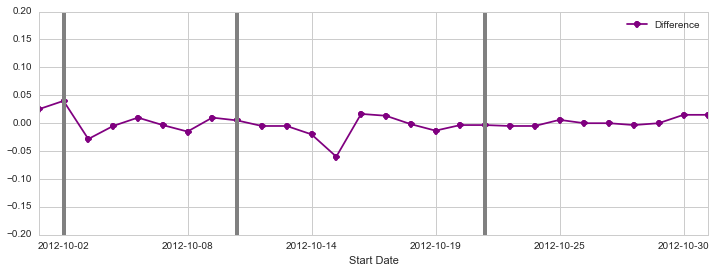

In [21]:
# まずは10月に限定したプロットです。
fig = poll_df.plot('Start Date','Difference',figsize=(12,4),marker='o',linestyle='-',color='purple',xlim=(329,356))

# 討論会の日程を描き込みます。
plt.axvline(x=330, linewidth=4, color='grey')
plt.axvline(x=337, linewidth=4, color='grey')
plt.axvline(x=347, linewidth=4, color='grey')

米国大統領選挙に馴染みが薄いので、データの解釈は難しいですが、このような解析が役に立つのはおわかりいただけるかと思います。

こうしたデータを解釈する際は、様々な要因に注意を払う必要もあります。例えば、これらの世論調査が全米のどの場所で行われたかなども、世論調査の結果に大きく影響します。

<hr>

# 寄付のデータ

話題を変えて、両陣営への寄付に関するデータを分析していくことにします。

これまでで一番大きなデータセット（約150MB)になります。[ここからダウンロード出来ます](https://www.dropbox.com/s/ltyfa5eba9a4tcm/Election_Donor_Data.csv?dl=0) , Notebookが起動しているフォルダと同じ場所に保存しておきましょう。

このデータは、次の視点から分析を進めることにします。

    1.) 寄付の金額とその平均的な額
    2.) 候補者ごとの寄付の違い
    3.) 民主党と共和党での寄付の違い
    4.) 寄付した人々の属性について
    5.) 寄付の総額になんらかのパターンがあるか？
    

In [22]:
# CSV形式のデータを読み込んで、DataFrameを作ります。
donor_df = pd.read_csv('Election_Donor_Data.csv')

//anaconda/lib/python3.4/site-packages/pandas/io/parsers.py:1170: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  data = self._reader.read(nrows)


In [23]:
# データの概要です。
donor_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1001731 entries, 0 to 1001730
Data columns (total 16 columns):
cmte_id              1001731 non-null object
cand_id              1001731 non-null object
cand_nm              1001731 non-null object
contbr_nm            1001731 non-null object
contbr_city          1001712 non-null object
contbr_st            1001727 non-null object
contbr_zip           1001620 non-null object
contbr_employer      988002 non-null object
contbr_occupation    993301 non-null object
contb_receipt_amt    1001731 non-null float64
contb_receipt_dt     1001731 non-null object
receipt_desc         14166 non-null object
memo_cd              92482 non-null object
memo_text            97770 non-null object
form_tp              1001731 non-null object
file_num             1001731 non-null int64
dtypes: float64(1), int64(1), object(14)
memory usage: 129.9+ MB


In [24]:
# 最初の5行を見てみます。
donor_df.head()

,cmte_id,cand_id,cand_nm,contbr_nm,contbr_city,contbr_st,contbr_zip,contbr_employer,contbr_occupation,contb_receipt_amt,contb_receipt_dt,receipt_desc,memo_cd,memo_text,form_tp,file_num
0,C00410118,P20002978,"Bachmann, Michelle","HARVEY, WILLIAM",MOBILE,AL,3.660103e+08,RETIRED,RETIRED,250,20-JUN-11,NaN,NaN,NaN,SA17A,736166
1,C00410118,P20002978,"Bachmann, Michelle","HARVEY, WILLIAM",MOBILE,AL,3.660103e+08,RETIRED,RETIRED,50,23-JUN-11,NaN,NaN,NaN,SA17A,736166
2,C00410118,P20002978,"Bachmann, Michelle","SMITH, LANIER",LANETT,AL,3.686334e+08,INFORMATION REQUESTED,INFORMATION REQUESTED,250,05-JUL-11,NaN,NaN,NaN,SA17A,749073
3,C00410118,P20002978,"Bachmann, Michelle","BLEVINS, DARONDA",PIGGOTT,AR,7.245483e+08,NONE,RETIRED,250,01-AUG-11,NaN,NaN,NaN,SA17A,749073
4,C00410118,P20002978,"Bachmann, Michelle","WARDENBURG, HAROLD",HOT SPRINGS NATION,AR,7.190165e+08,NONE,RETIRED,300,20-JUN-11,NaN,NaN,NaN,SA17A,736166


まずは、寄付の総額と平均的な額を計算してみることにしましょう。

In [25]:
# 寄付の額をざっと眺めてみます。
donor_df['contb_receipt_amt'].value_counts()
#donor_df['contb_receipt_amt'].value_counts().shape

 100.00     178188
 50.00      137584
 25.00      110345
 250.00      91182
 500.00      57984
 2500.00     49005
 35.00       37237
 1000.00     36494
 10.00       33986
 200.00      27813
 20.00       17565
 15.00       16163
 150.00      14600
 75.00       13647
 201.20      11718
 30.00       11381
 300.00      11204
 20.12        9897
 5.00         9024
 40.00        5007
 2000.00      4128
 55.00        3760
 1500.00      3705
 3.00         3383
 60.00        3084
 400.00       3066
-2500.00      2727
 110.00       2554
 125.00       2520
 19.00        2474
             ...  
 48.72           1
 51.03           1
 52.09           1
 59.84           1
 61.03           1
 19.53           1
 18.53           1
-23.22           1
-169.10          1
-245.16          1
-239.58          1
-235.40          1
-234.96          1
-218.97          1
-214.27          1
-210.52          1
-200.09          1
-173.15          1
-165.08          1
-60.41           1
-152.40          1
-150.78     

8079種類もあるのにはちょっと驚きです。代表値を計算してみましょう。

In [26]:
# 寄付の平均的な額
don_mean = donor_df['contb_receipt_amt'].mean()

# 標準偏差
don_std = donor_df['contb_receipt_amt'].std()

print('寄付の平均は{:0.2f}ドルで、その標準偏差は{:0.2f}です。'.format(don_mean,don_std))

寄付の平均は298.24ドルで、その標準偏差は3749.67です。


ものすごく大きな標準偏差です。
非常に大きな値があるのでしょうか？分布の形がかなり偏っていることが予想されます。

In [27]:
# DataFrameの1列から、Seriesを作ります。
top_donor = donor_df['contb_receipt_amt'].copy()

# ソートしましょう。
top_donor.sort()

top_donor

114604     -30800.00
226986     -25800.00
101356      -7500.00
398429      -5500.00
250737      -5455.00
33821       -5414.31
908565      -5115.00
456649      -5000.00
574657      -5000.00
30513       -5000.00
562267      -5000.00
30584       -5000.00
86268       -5000.00
708920      -5000.00
665887      -5000.00
708899      -5000.00
708929      -5000.00
21172       -5000.00
21168       -5000.00
21167       -5000.00
262328      -5000.00
946875      -5000.00
7361        -5000.00
416403      -5000.00
21164       -5000.00
707945      -5000.00
615101      -5000.00
7973        -5000.00
54430       -5000.00
54434       -5000.00
             ...    
708022      10000.00
708898      10000.00
710177      10000.00
876244      10000.00
709608      10000.00
708919      10000.00
709739      10000.00
91145       10000.00
708138      10000.00
993178      10000.00
709813      10000.00
710730      10000.00
708928      10000.00
709268      10000.00
99829       10000.00
90076       10000.00
709859      1

負の数や、非常に大きな値が見えます。
負の数は、払い戻しのデータなどですので、ひとまず正の数だけに注目することにしましょう。

In [28]:
# 負の数を取り除きます。
top_donor = top_donor[top_donor >0]

# ソートします
top_donor.sort()

# よく寄付される額Top10をみてみましょう。
top_donor.value_counts().head(10)

100     178188
50      137584
25      110345
250      91182
500      57984
2500     49005
35       37237
1000     36494
10       33986
200      27813
dtype: int64

Top10でも、10ドルから2,500ドルまで幅広いことがわかります。

寄付の額は、10や50などキリの良い数字が多いのかどう書きになります。
ヒストグラムを描いて、2,500ドルまでのデータを調べてみましょう。

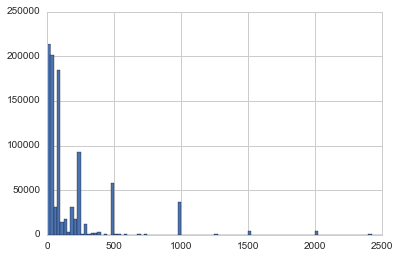

In [29]:
# 2,500ドルまでの寄付のデータを取り出します。
com_don = top_donor[top_donor < 2500]

# binを細かくして、キリのいい数字にピークがあるか、見てみましょう。
com_don.hist(bins=100)

どうやら、我々の直感は正しかったようです。

<hr>

政党ごとに寄付の額をまとめて見ることにします。
これをするには、まず候補者のデータに注目して、候補者の所属政党でデータを分類する事を試みます。

In [30]:
# 重複の無い候補者のデータを作って置きます。
candidates = donor_df.cand_nm.unique()
candidates

array(['Bachmann, Michelle', 'Romney, Mitt', 'Obama, Barack',
       "Roemer, Charles E. 'Buddy' III", 'Pawlenty, Timothy',
       'Johnson, Gary Earl', 'Paul, Ron', 'Santorum, Rick', 'Cain, Herman',
       'Gingrich, Newt', 'McCotter, Thaddeus G', 'Huntsman, Jon',
       'Perry, Rick'], dtype=object)

新たに、Party列を作ります。候補者の所属政党のデータを保持する辞書を作って、一気にDataFrameを更新しましょう。 (詳しくはLecture 36にあります）

In [31]:
# 所属政党の辞書です。
party_map = {'Bachmann, Michelle': 'Republican',
           'Cain, Herman': 'Republican',
           'Gingrich, Newt': 'Republican',
           'Huntsman, Jon': 'Republican',
           'Johnson, Gary Earl': 'Republican',
           'McCotter, Thaddeus G': 'Republican',
           'Obama, Barack': 'Democrat',
           'Paul, Ron': 'Republican',
           'Pawlenty, Timothy': 'Republican',
           'Perry, Rick': 'Republican',
           "Roemer, Charles E. 'Buddy' III": 'Republican',
           'Romney, Mitt': 'Republican',
           'Santorum, Rick': 'Republican'}

# 以下のコードで、DataFrame全体を更新できます。
donor_df['Party'] = donor_df.cand_nm.map(party_map)

もちろん、for文を使って同じ操作をすることが可能ですが、mapを使う方が早く終わります。

In [32]:
'''
for i in xrange(0,len(donor_df)):
    if donor_df['cand_nm'][i] == 'Obama,Barack':
        donor_df['Party'][i] = 'Democrat'
    else:
        donor_df['Party'][i] = 'Republican'
'''

"\nfor i in xrange(0,len(donor_df)):\n    if donor_df['cand_nm'][i] == 'Obama,Barack':\n        donor_df['Party'][i] = 'Democrat'\n    else:\n        donor_df['Party'][i] = 'Republican'\n"

払い戻しのデータを除去しておきましょう。完成したデータは次のような感じです。

In [33]:
# 払い戻しの除去
donor_df = donor_df[donor_df.contb_receipt_amt >0]

donor_df.head()

,cmte_id,cand_id,cand_nm,contbr_nm,contbr_city,contbr_st,contbr_zip,contbr_employer,contbr_occupation,contb_receipt_amt,contb_receipt_dt,receipt_desc,memo_cd,memo_text,form_tp,file_num,Party
0,C00410118,P20002978,"Bachmann, Michelle","HARVEY, WILLIAM",MOBILE,AL,3.660103e+08,RETIRED,RETIRED,250,20-JUN-11,NaN,NaN,NaN,SA17A,736166,Republican
1,C00410118,P20002978,"Bachmann, Michelle","HARVEY, WILLIAM",MOBILE,AL,3.660103e+08,RETIRED,RETIRED,50,23-JUN-11,NaN,NaN,NaN,SA17A,736166,Republican
2,C00410118,P20002978,"Bachmann, Michelle","SMITH, LANIER",LANETT,AL,3.686334e+08,INFORMATION REQUESTED,INFORMATION REQUESTED,250,05-JUL-11,NaN,NaN,NaN,SA17A,749073,Republican
3,C00410118,P20002978,"Bachmann, Michelle","BLEVINS, DARONDA",PIGGOTT,AR,7.245483e+08,NONE,RETIRED,250,01-AUG-11,NaN,NaN,NaN,SA17A,749073,Republican
4,C00410118,P20002978,"Bachmann, Michelle","WARDENBURG, HAROLD",HOT SPRINGS NATION,AR,7.190165e+08,NONE,RETIRED,300,20-JUN-11,NaN,NaN,NaN,SA17A,736166,Republican


候補者ごとに寄付の額をまとめてみます。
まずはじめに、寄付の件数から。

In [34]:
# 候補者の名前でグループ化したあと、それぞれの寄付件数を表示します。
donor_df.groupby('cand_nm')['contb_receipt_amt'].count()

cand_nm
Bachmann, Michelle                 13082
Cain, Herman                       20052
Gingrich, Newt                     46883
Huntsman, Jon                       4066
Johnson, Gary Earl                  1234
McCotter, Thaddeus G                  73
Obama, Barack                     589127
Paul, Ron                         143161
Pawlenty, Timothy                   3844
Perry, Rick                        12709
Roemer, Charles E. 'Buddy' III      5844
Romney, Mitt                      105155
Santorum, Rick                     46245
Name: contb_receipt_amt, dtype: int64

オバマの圧勝です。それもそのはず。彼は民主党からの唯一の候補者なので、寄付が集まっているわけです。寄付の額を見てみましょう。

In [35]:
# グループ化したあと、今度は寄付の総額を表示します。
donor_df.groupby('cand_nm')['contb_receipt_amt'].sum()

cand_nm
Bachmann, Michelle                2.711439e+06
Cain, Herman                      7.101082e+06
Gingrich, Newt                    1.283277e+07
Huntsman, Jon                     3.330373e+06
Johnson, Gary Earl                5.669616e+05
McCotter, Thaddeus G              3.903000e+04
Obama, Barack                     1.358774e+08
Paul, Ron                         2.100962e+07
Pawlenty, Timothy                 6.004819e+06
Perry, Rick                       2.030575e+07
Roemer, Charles E. 'Buddy' III    3.730099e+05
Romney, Mitt                      8.833591e+07
Santorum, Rick                    1.104316e+07
Name: contb_receipt_amt, dtype: float64

ちょっと読みにくいので、少し結果を整形することにします。

In [36]:
# データの準備です。
cand_amount = donor_df.groupby('cand_nm')['contb_receipt_amt'].sum()

# indexアクセスのための変数を用意します。
i = 0

for don in cand_amount:
    print("{}は、{:.0f}ドル集めました。\n".format(cand_amount.index[i],don))
    i += 1

Bachmann, Michelleは、2711439ドル集めました。

Cain, Hermanは、7101082ドル集めました。

Gingrich, Newtは、12832770ドル集めました。

Huntsman, Jonは、3330373ドル集めました。

Johnson, Gary Earlは、566962ドル集めました。

McCotter, Thaddeus Gは、39030ドル集めました。

Obama, Barackは、135877427ドル集めました。

Paul, Ronは、21009620ドル集めました。

Pawlenty, Timothyは、6004819ドル集めました。

Perry, Rickは、20305754ドル集めました。

Roemer, Charles E. 'Buddy' IIIは、373010ドル集めました。

Romney, Mittは、88335908ドル集めました。

Santorum, Rickは、11043159ドル集めました。



文字での表示より、やはりグラフ表示がいいかもしれません。

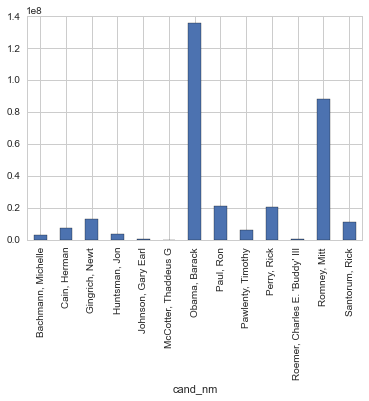

In [37]:
# 棒グラフを描いてみましょう。
cand_amount.plot(kind='bar')

比較が簡単になりました。
オバマ候補だけで100億円以上のお金が寄付で集まっているのがわかります。
今度は、政党別で比較してみましょう。

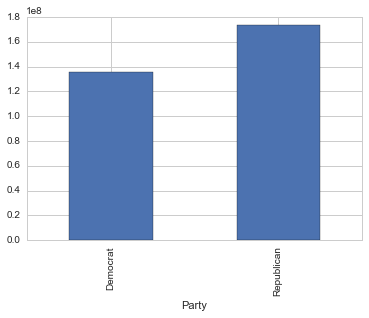

In [38]:
# 政党ごとの寄付の額です。
donor_df.groupby('Party')['contb_receipt_amt'].sum().plot(kind='bar')

民主党（Democrat）はオバマ候補1人ですので、政党の比較では、共和党優勢ですが、共和党候補者達は、この額をみんなで分けているので、個人でみると厳しい情勢です。

最後に、寄付した人達の職業をまとめてみましょう。
まず、職業のデータを元のDataFrameから抜き出して、これをもとに、ピボットテーブルを作ります。このとき、職業ごとに民主党と共和党への寄付額が分かるようにします。
最後にこれらのデータをまとめて、寄付者の属性ごとの寄付額を算出してみましょう。

In [51]:
# 職業ごとに、政党別に分けて寄付額をまとめます。
occupation_df = donor_df.pivot_table('contb_receipt_amt',
                                index='contbr_occupation',
                                columns='Party', aggfunc='sum')

In [52]:
occupation_df.head(10)

Party,Democrat,Republican
contbr_occupation,,
MIXED-MEDIA ARTIST / STORYTELLER,100,NaN
AREA VICE PRESIDENT,250,NaN
RESEARCH ASSOCIATE,100,NaN
TEACHER,500,NaN
THERAPIST,3900,NaN
'MIS MANAGER,NaN,177.6
(PART-TIME) SALES CONSULTANT & WRITER,NaN,285.0
(RETIRED),NaN,250.0
-,5000,2114.8


DataFrameのサイズを見ておきましょう。

In [53]:
occupation_df.shape

(45067, 2)

4万5千以上の職種があるようで、簡単には描画できそうにありません。
閾値を決めて、寄付の総額が小さい職種については、表示を省略するようにしてみます。

In [58]:
# 百万ドル（約1億2千万）をひとつの区切りにしてみます。
occupation_df = occupation_df[occupation_df.sum(1) > 1000000]

In [57]:
# サイズを見てみましょう。
occupation_df.shape

(45067, 2)

これなら、グラフにできそうです。

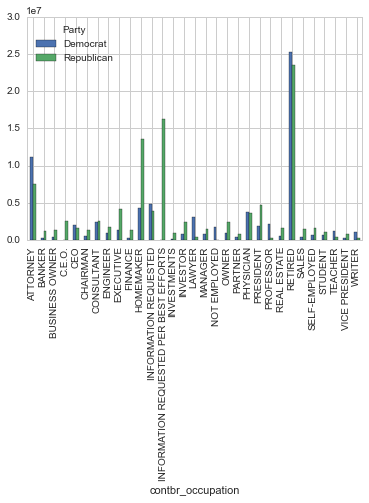

In [45]:
# pandasの機能を使って、棒グラフを描いてみます。
occupation_df.plot(kind='bar')

kind = 'barh' (horizontal)とすると、横向きになります。

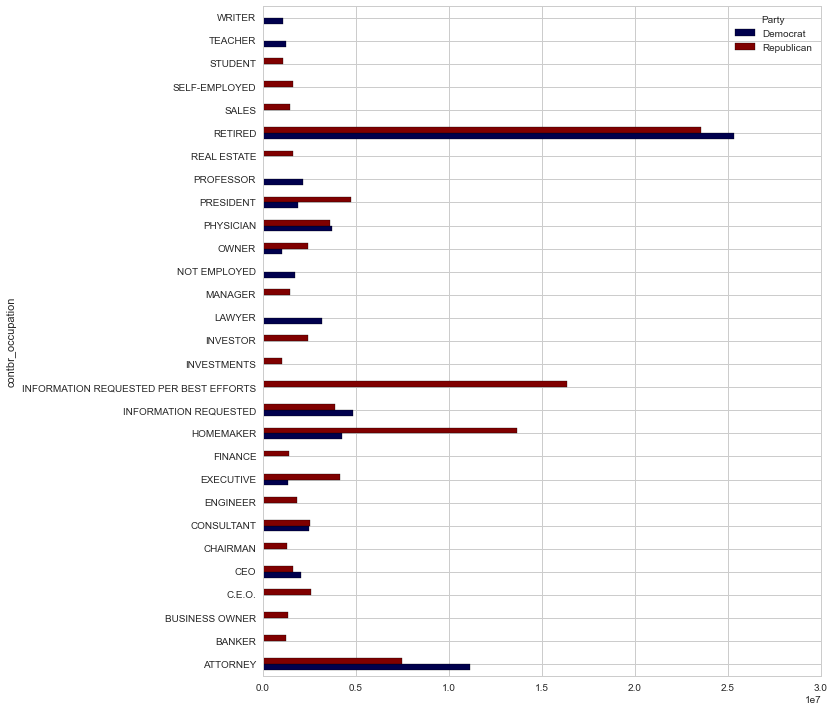

In [60]:
# 横向き（水平：Horizontal）な図が描けました。
occupation_df.plot(kind='barh',figsize=(10,12),cmap='seismic')

In [59]:
occupation_df

Party,Democrat,Republican
contbr_occupation,,
ATTORNEY,11141982.97,7477194.430000
BANKER,NaN,1259468.730000
BUSINESS OWNER,NaN,1323342.430000
C.E.O.,NaN,2592983.110000
CEO,2073284.79,1618057.410000
CHAIRMAN,NaN,1296092.750000
CONSULTANT,2459912.71,2544725.450000
ENGINEER,NaN,1818373.700000
EXECUTIVE,1355161.05,4138850.090000


色々と粗が目立ちます。ひとまず、「Information Requested」を取り除いて、「CEO」と「C.E.O.」を1つにまとめてみます。

In [51]:
# 無効な回答を取り除きます。
occupation_df.drop(['INFORMATION REQUESTED PER BEST EFFORTS','INFORMATION REQUESTED'],axis=0,inplace=True)

CEOとC.E.Oをまとめましょう。

In [ ]:
# CEOにまとめます。
occupation_df.loc['CEO'] = occupation_df.loc['CEO'] + occupation_df.loc['C.E.O.']
# C.E.O.を消しましょう。
occupation_df.drop('C.E.O.',inplace=True)

再び、プロットします。

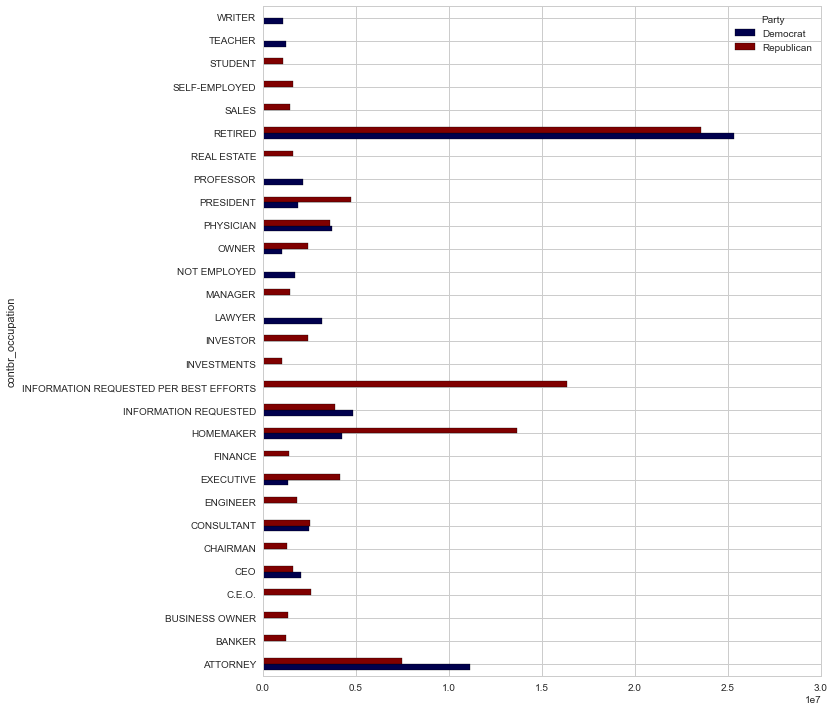

In [61]:
occupation_df.plot(kind='barh',figsize=(10,12),cmap='seismic')

CEO（企業経営者）は、保守的な思想の持ち主のように見えます。両党の税に対する考え方が反映されているのかも知れません。

### お疲れ様でした
選挙に関するデータを一通り解析しました。大きなデータセットなので、工夫次第でまだまだやれることがあると思いますので、是非チャレンジしてみてください。

日本でも、選挙に関するデータ解析の事例があります。是非、参考にしてみてください。
http://event.yahoo.co.jp/bigdata/senkyo201307/